In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data
df = pd.read_csv("../data/complete-merged-df.csv", index_col=0, parse_dates=True)
df.head()

,close,open,high,low,estimated-transaction-volume-usd,n-transactions,hash-rate,difficulty,cost-per-transaction,Gold price,output-volume,trade-volume,USD-CNY Price,SVI,Wikiviews
2017-01-01,998.079443,966.567909,1005.074602,961.719392,1.667890e+08,180502.0,2.463611e+06,3.176884e+11,10.914479,1377.316553,1.084341e+06,3.989748e+06,6.72991,7.000000,3139
2017-01-02,1018.369458,998.079638,1033.051602,994.997792,2.799811e+08,290951.0,2.526780e+06,3.176884e+11,7.350606,1294.600000,1.573982e+06,6.822471e+06,6.94500,18.574713,9165
2017-01-03,1036.750461,1018.367417,1037.211425,1014.576142,3.417543e+08,301664.0,2.589950e+06,3.176884e+11,7.415466,1295.600000,1.950525e+06,8.324526e+06,6.96100,18.574713,12354
2017-01-04,1137.239897,1036.750186,1146.956329,1036.327096,4.336781e+08,328642.0,2.432026e+06,3.176884e+11,7.000531,1287.300000,2.482038e+06,9.340584e+06,6.93510,18.574713,10757
2017-01-05,1002.860000,1137.239606,1165.785631,883.480930,5.657800e+08,288501.0,2.210933e+06,3.176884e+11,6.913398,1287.400000,2.998215e+06,2.387011e+07,6.89000,18.574713,11938


In [5]:
# understand the data
# print("Number of Features: ", len(df.columns)-1)
# print("Number of Samples: ", len(df))
# print("Number of Missing Values: ", df.isnull().sum().sum())
# print("Data Types: ", df.dtypes)
# print("Start Date: ", df.index[0])
# print("End Date: ", df.index[-1])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2017-01-01 to 2021-12-31
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   close                             1826 non-null   float64
 1   open                              1826 non-null   float64
 2   high                              1826 non-null   float64
 3   low                               1826 non-null   float64
 4   estimated-transaction-volume-usd  1826 non-null   float64
 5   n-transactions                    1826 non-null   float64
 6   hash-rate                         1826 non-null   float64
 7   difficulty                        1826 non-null   float64
 8   cost-per-transaction              1826 non-null   float64
 9   Gold price                        1826 non-null   float64
 10  output-volume                     1826 non-null   float64
 11  trade-volume                      1826 non-null   f

### Helper functions

In [3]:
import yfinance as yf
from yahoofinancials import YahooFinancials
from datetime import date

# get new data from yahoo finance
def get_new_data(ticker, start_date, end_date=date.today()):
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    return data

In [4]:
def get_prediction(model, X, scaler):
    # make predictions
    predictions = model.predict(X)
    # inverse transform predictions
    inv_predictions = inverse_transform(predictions, scaler)
    return inv_predictions


In [5]:
def plot_history(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()


In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 1:]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [7]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]   # corr
    mins = np.amin(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return({'mape': str(round(mape*100, 3))+"%", 'mae': mae, 'rmse': rmse})
    # return({'mape': str(round(mape*100, 3))+"%", 'me': me, 'mae': mae,
    #         'mpe': mpe, 'rmse': rmse,
    #         'corr': corr, 'minmax': minmax})

# accuracy comparisons


def pprint(d):
    for key, value in d.items():
        print(f"\t{key}: {value}")


In [8]:
# plot predictions and return a merged dataframe of all the predictions against the actual values
def plot_predictions(predictions, actual):
    pred_df = pd.DataFrame()
    pred_df['Actual'] = actual
    try:
        plt.figure(figsize=(12, 8))
        for idx, prediction in enumerate(predictions):
            plt.plot(prediction, label=f'Model-{idx+1}')
            pred_df[f'Prediction-{idx+1}'] = prediction
    except ValueError as e:
        print('Error:', e)

    print(pred_df)
    plt.plot(actual, label='Actual')
    plt.legend()
    plt.show()

    return pred_df


def plot_future(past, predictions: list, actual):
    plt.figure(figsize=(15, 8))
    for idx, prediction in enumerate(predictions):
        plt.plot(prediction, label=f'Model-{idx+1}')
    # plt.plot(predicted, label='Predicted Stock Price')
    plt.plot(actual, color='g', label='Actual Future Stock Price')
    plt.plot(past, color='r', label='Actual Stock Price')

    plt.axvline(x=min(predictions_future.index),
                color='green', linewidth=2, linestyle='--')
    plt.xticks(rotation=45, fontsize=8)
    plt.legend(shadow=True, loc='upper right')


In [9]:
def inverse_transform(X, scaler, features=15):
    # Get something which has as many features as dataset
    extended = np.zeros((len(X), features))
    # Put the predictions there
    extended[:, 0:] = X
    # Inverse transform it and select the 3rd column.
    return scaler.inverse_transform(extended)[:,0]

## Data preprocessing and preparation


In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [11]:
# CONsTS
dataset = df.values  # get raw values from dataframe
TIMESTEPS = 30 # n days in the future to predcict
TRAIN_SIZE = int(len(dataset) * 0.8)  # 80% training set
TEST_SIZE = len(dataset) - TRAIN_SIZE  # 20% test set
FEATURES = 14  # number of features

In [12]:
# normalize the dataset
# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train, test = dataset[:TRAIN_SIZE, :], dataset[TRAIN_SIZE:len(dataset), :]

# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train, TIMESTEPS)
testX, testY = create_dataset(test, TIMESTEPS)

# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], TIMESTEPS, FEATURES))
testX = np.reshape(testX, (testX.shape[0], TIMESTEPS, FEATURES))

In [13]:
# Input shape for LSTM : (time steps, features)
input = (trainX.shape[1], trainX.shape[2])
input

(30, 14)

## Build and fit model

In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20224     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 20,289
Trainable params: 20,289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
30/30 [==============================] - 11s 59ms/step - loss: 0.0016 - mean_absolute_error: 0.0289 - val_loss: 0.0011 - val_mean_absolute_error: 0.0302
Epoch 2/20
30/30 [==============================] - 1s 27ms/step - loss: 2.7574e-04 - mean_absolute_error: 0.0109 - val_loss: 8.4106e-04 - val_mean_absolute_error: 0.0252
Epoch 3/20
30/30 [==============================] - 1s 22ms/step - loss: 2.1876e-04 - mean_absolute_error: 0.0085

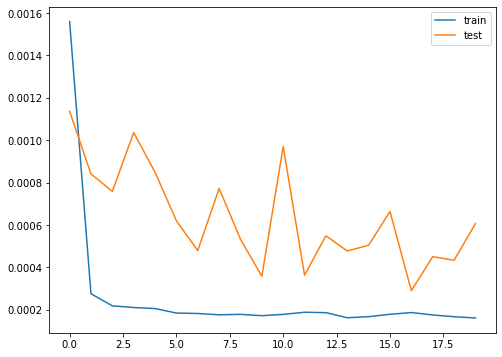

In [15]:
# model1
model = Sequential()

# LSTM layers
model.add(LSTM(64, activation='tanh', input_shape=input))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mean_absolute_error'])
model.summary()

# fit network and plot history
history = model.fit(trainX, trainY, validation_split=0.33, epochs=20, batch_size=32)
plot_history(history)

           Actual  Prediction-1
0    33138.745496  29909.341923
1    33533.900000  29394.361892
2    35514.809100  29646.467818
3    37692.000000  29398.678318
4    36995.561559  30045.493411
..            ...           ...
330  50696.802160  44948.980912
331  47535.309698  44757.513901
332  46471.230000  44409.652579
333  47128.468155  43837.687371
334  46208.210437  43206.975789

[335 rows x 2 columns]


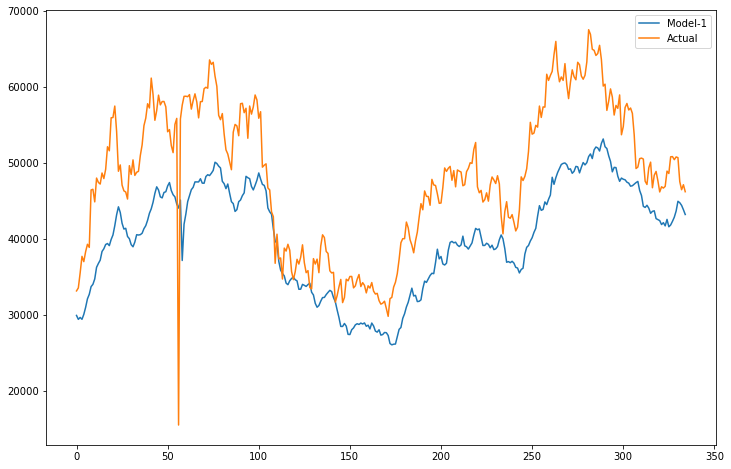

In [16]:
# make predictions: model 1
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# inverse transform predictions
inv_train_yhat = inverse_transform(trainPredict, scaler)
inv_test_yhat = inverse_transform(testPredict, scaler)
test_period = df[-len(inv_test_yhat):].close.values

# plot predictions
predictions = plot_predictions([inv_test_yhat], test_period)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 128)           73216     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

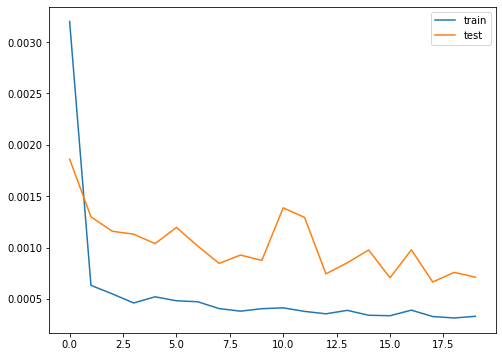

In [17]:
# model2
model2 = Sequential()

# LSTM layers
model2.add(LSTM(units=128, activation='tanh', return_sequences=True, input_shape=input)) # Input layer

# Hidden layers
model2.add(Dropout(0.2))
model2.add(LSTM(units=64, activation='tanh', return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=32, activation='tanh', return_sequences=False))
model2.add(Dropout(0.2))

model2.add(Dense(units=1))  # Output layer

model2.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mean_absolute_error'])
model2.summary()

history2 = model2.fit(trainX, trainY, validation_split=0.3, epochs=20, batch_size=32)
plot_history(history2)


           Actual  Prediction-1  Prediction-2
0    33138.745496  29909.341923  23364.247564
1    33533.900000  29394.361892  23414.241684
2    35514.809100  29646.467818  23438.916355
3    37692.000000  29398.678318  23456.868626
4    36995.561559  30045.493411  23560.164334
..            ...           ...           ...
330  50696.802160  44948.980912  28296.160912
331  47535.309698  44757.513901  28345.872444
332  46471.230000  44409.652579  28434.091508
333  47128.468155  43837.687371  28524.680726
334  46208.210437  43206.975789  28590.268903

[335 rows x 3 columns]


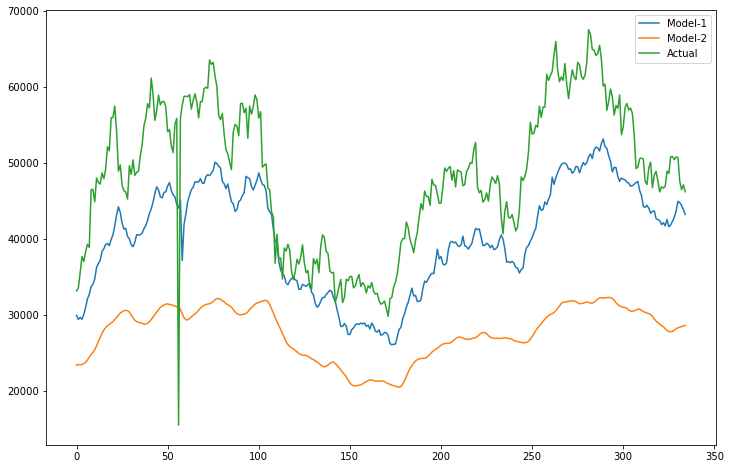

,Actual,Prediction-1,Prediction-2
0,33138.745496,29909.341923,23364.247564
1,33533.900000,29394.361892,23414.241684
2,35514.809100,29646.467818,23438.916355
3,37692.000000,29398.678318,23456.868626
4,36995.561559,30045.493411,23560.164334
...,...,...,...
330,50696.802160,44948.980912,28296.160912
331,47535.309698,44757.513901,28345.872444
332,46471.230000,44409.652579,28434.091508
333,47128.468155,43837.687371,28524.680726


In [18]:
# make predictions
trainPredict2 = model2.predict(trainX)
testPredict2 = model2.predict(testX)

# inverse
inv_train_yhat2 = inverse_transform(trainPredict2, scaler)
inv_test_yhat2 = inverse_transform(testPredict2, scaler)

#plot
plot_predictions([inv_test_yhat, inv_test_yhat2], df[-len(inv_test_yhat):].close.values)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                20224     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 20,289
Trainable params: 20,289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
45/45 [==============================] - 7s 43ms/step - loss: 0.0013 - mean_absolute_error: 0.0256 - val_loss: 0.0341 - val_mean_absolute_error: 0.1688
Epoch 2/20
45/45 [==============================] - 1s 20ms/step - loss: 2.7822e-04 - mean_absolute_error: 0.0111 - val_loss: 0.0144 - val_mean_absolute_error: 0.1019
Epoch 3/20
45/45 [==============================] - 1s 19ms/step - loss: 2.1773e-04 - mean_absolute_error: 0.0089 - 

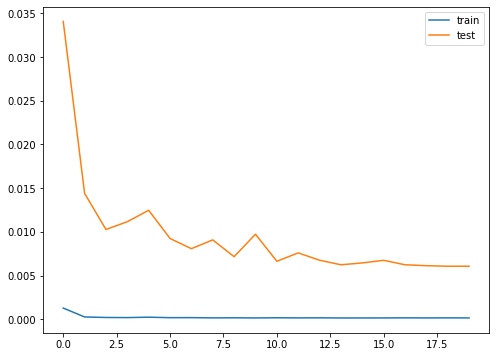

In [19]:
# model3: with validation input
model3 = Sequential()

model3.add(LSTM(64, activation='tanh', input_shape=input))
# model3.add(Dense(64))
model3.add(Dense(1))
# model3.compile(loss='mean_squared_error', optimizer='adam')
model3.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mean_absolute_error'])

model3.summary()
# split test into validation and test
validation_size = int(len(testX) * 0.33)
validationX, testX = testX[:validation_size, :], testX[validation_size:, :]
validationY, testY = testY[:validation_size], testY[validation_size:]

history3 = model3.fit(trainX, trainY, validation_data=(
    validationX, validationY), epochs=20, batch_size=32)

plot_history(history3)


Error: Length of values (225) does not match length of index (335)
           Actual  Prediction-1  Prediction-2
0    33138.745496  29909.341923  23364.247564
1    33533.900000  29394.361892  23414.241684
2    35514.809100  29646.467818  23438.916355
3    37692.000000  29398.678318  23456.868626
4    36995.561559  30045.493411  23560.164334
..            ...           ...           ...
330  50696.802160  44948.980912  28296.160912
331  47535.309698  44757.513901  28345.872444
332  46471.230000  44409.652579  28434.091508
333  47128.468155  43837.687371  28524.680726
334  46208.210437  43206.975789  28590.268903

[335 rows x 3 columns]


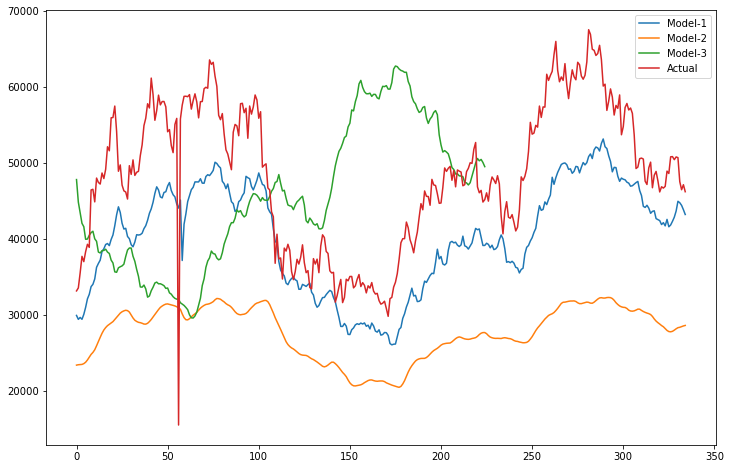

,Actual,Prediction-1,Prediction-2
0,33138.745496,29909.341923,23364.247564
1,33533.900000,29394.361892,23414.241684
2,35514.809100,29646.467818,23438.916355
3,37692.000000,29398.678318,23456.868626
4,36995.561559,30045.493411,23560.164334
...,...,...,...
330,50696.802160,44948.980912,28296.160912
331,47535.309698,44757.513901,28345.872444
332,46471.230000,44409.652579,28434.091508
333,47128.468155,43837.687371,28524.680726


In [20]:
# make predictions
trainPredict3 = model3.predict(trainX)
testPredict3 = model3.predict(testX)

# inverse
inv_train_yhat3 = inverse_transform(trainPredict3, scaler)
inv_test_yhat3 = inverse_transform(testPredict3, scaler)

#plot
plot_predictions([inv_test_yhat, inv_test_yhat2, inv_test_yhat3], df[-len(inv_test_yhat):].close.values)

In [23]:
# model4 with limited features
# top_predictors = ['close', 'open', 'high', 'low', 'n-transactions',  'SVI', 'estimated-transaction-volume-usd']
top_predictors = ['close', 'open', 'high', 'low', 'n-transactions', 'cost-per-transaction', 'Gold price', 'output-volume',  'USD-CNY Price', 'SVI', 'Wikiviews']
df4 = df[top_predictors]


# normalize the dataset
scaler4 = StandardScaler()
# scaler4 = MinMaxScaler(feature_range=(0, 1))
dataset4 = scaler4.fit_transform(df4.values)


# split into train and test sets
train4, test4 =  dataset4[:TRAIN_SIZE, :], dataset4[TRAIN_SIZE:len(dataset4), :]

# reshape into X=t and Y=t+1
trainX4, trainY4 = create_dataset(train4, TIMESTEPS)
testX4, testY4 = create_dataset(test4, TIMESTEPS)

# reshape input to be  [samples, time steps, features]
trainX4 = np.reshape(trainX4, (trainX4.shape[0], TIMESTEPS, len(top_predictors)-1))
testX4 = np.reshape(testX4, (testX4.shape[0], TIMESTEPS, len(top_predictors)-1))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                19200     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
30/30 [==============================] - 8s 82ms/step - loss: 0.0694 - val_loss: 0.0161
Epoch 2/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0051 - val_loss: 0.0158
Epoch 3/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0034 - val_loss: 0.0164
Epoch 4/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0030 - val_loss: 0.0151
Epoch 5/20
30/30 [==============================] 

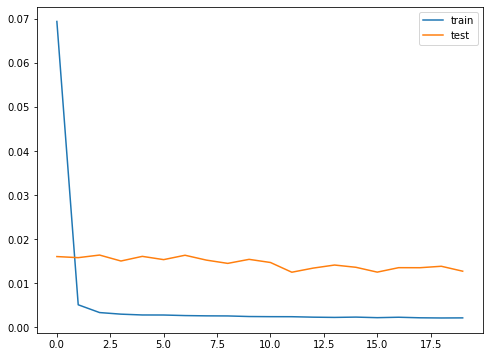

In [24]:
# since model3 performed the best, we will use it for model4
model4 = Sequential()

model4.add(LSTM(64, activation='tanh', input_shape=(trainX4.shape[1], trainX4.shape[2])))
model4.add(Dense(1))
model4.compile(loss='mean_squared_error', optimizer='adam')
# model3.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mean_absolute_error'])

model4.summary()
# history4= model4.fit(trainX4, trainY4, validation_data=(X_val,y_val), epochs=20, batch_size=32)
history4= model4.fit(trainX4, trainY4, validation_split=.33, epochs=20, batch_size=32)

plot_history(history4)


Error: Length of values (225) does not match length of index (335)
           Actual  Prediction-1  Prediction-2
0    33138.745496  29909.341923  23364.247564
1    33533.900000  29394.361892  23414.241684
2    35514.809100  29646.467818  23438.916355
3    37692.000000  29398.678318  23456.868626
4    36995.561559  30045.493411  23560.164334
..            ...           ...           ...
330  50696.802160  44948.980912  28296.160912
331  47535.309698  44757.513901  28345.872444
332  46471.230000  44409.652579  28434.091508
333  47128.468155  43837.687371  28524.680726
334  46208.210437  43206.975789  28590.268903

[335 rows x 3 columns]


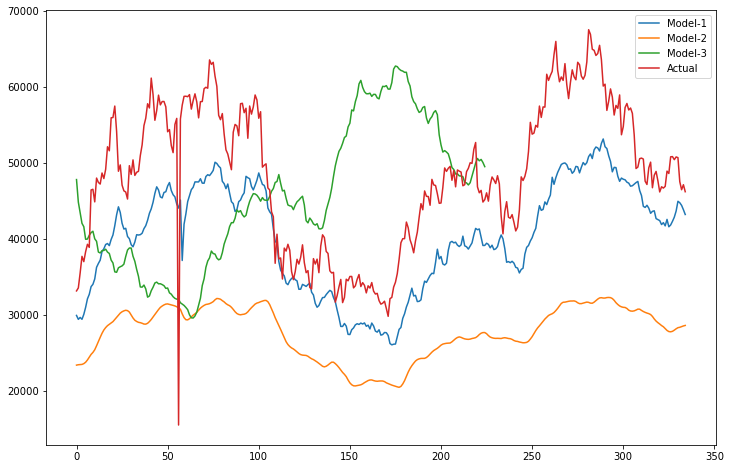

,Actual,Prediction-1,Prediction-2
0,33138.745496,29909.341923,23364.247564
1,33533.900000,29394.361892,23414.241684
2,35514.809100,29646.467818,23438.916355
3,37692.000000,29398.678318,23456.868626
4,36995.561559,30045.493411,23560.164334
...,...,...,...
330,50696.802160,44948.980912,28296.160912
331,47535.309698,44757.513901,28345.872444
332,46471.230000,44409.652579,28434.091508
333,47128.468155,43837.687371,28524.680726


In [25]:
# make predictions
trainPredict4 = model4.predict(trainX4)
testPredict4 = model4.predict(testX4)

# inverse
inv_train_yhat4 = inverse_transform(trainPredict4, scaler4, len(top_predictors))
inv_test_yhat4 = inverse_transform(testPredict4, scaler4, len(top_predictors))

#plot
plot_predictions([inv_test_yhat, inv_test_yhat2, inv_test_yhat3, inv_test_yhat4], df[-len(inv_test_yhat):].close.values)

In [26]:
print("Model 1:")
pprint(forecast_accuracy(inv_test_yhat, df[-len(inv_test_yhat):].close.values))
print("Model 2:")
pprint(forecast_accuracy(inv_test_yhat2, df[-len(inv_test_yhat2):].close.values))
print("Model 3:")
pprint(forecast_accuracy(inv_test_yhat3, df[-len(inv_test_yhat3):].close.values))
print("Model 4:")
pprint(forecast_accuracy(inv_test_yhat4, df[-len(inv_test_yhat4):].close.values))

Model 1:
	mape: 17.11%
	mae: 8370.094676964449
	rmse: 9332.795268478478
Model 2:
	mape: 42.141%
	mae: 20825.915258335594
	rmse: 21836.988351971773
Model 3:
	mape: 6.241%
	mae: 2882.332393865433
	rmse: 3617.3648749065796
Model 4:
	mape: 52.143%
	mae: 25956.845171254685
	rmse: 27364.858727769


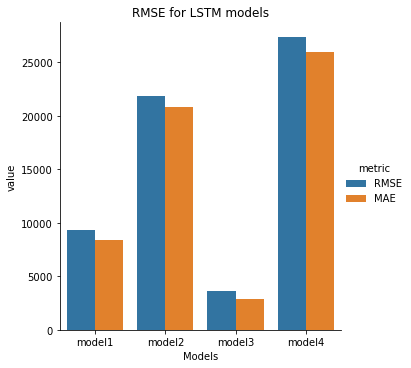

In [27]:
m1 =forecast_accuracy(inv_test_yhat, df[-len(inv_test_yhat):].close.values)
m2 = forecast_accuracy(inv_test_yhat2, df[-len(inv_test_yhat2):].close.values)
m3 = forecast_accuracy(inv_test_yhat3, df[-len(inv_test_yhat3):].close.values)
m4 = forecast_accuracy(inv_test_yhat4, df[-len(inv_test_yhat4):].close.values)

metrics = pd.DataFrame(data={'model': ['model1', 'model2', 'model3', 'model4'],
                          'RMSE': [m1['rmse'], m2['rmse'], m3['rmse'], m4['rmse']],
                          'MAE': [m1['mae'], m2['mae'], m3['mae'], m4['mae']]
                          }
                    )
metrics['RMSE'] = metrics['RMSE'].astype(float)
metrics['MAE'] = metrics['MAE'].astype(float)

metrics = pd.melt(metrics, id_vars="model")
metrics.columns = ['model', 'metric', 'value']

sns.factorplot(x='model', y='value', hue='metric', data=metrics, kind='bar')
plt.xlabel("Models")
plt.title('RMSE for LSTM models')
plt.show()


## Future predictions

In [28]:
yf_df = get_new_data('BTC-USD', '2020-12-31') 

In [78]:
# use saved model
from keras.models import load_model

saved_model = load_model('./saved_models/model3-5.756.h5')
saved_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                20224     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 20,289
Trainable params: 20,289
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(df.index[-1], periods=TIMESTEPS, freq='1d').tolist()

# make a prediction on based on the past 30 days
saved_yhat = get_prediction(model3, testX[-TIMESTEPS:], scaler)
predictions_future = pd.DataFrame(saved_yhat, columns=['Prediction']).set_index(pd.Series(datelist_future))
predictions_future['Actual'] = yf_df.loc[min(predictions_future.index):max(predictions_future.index)].Close


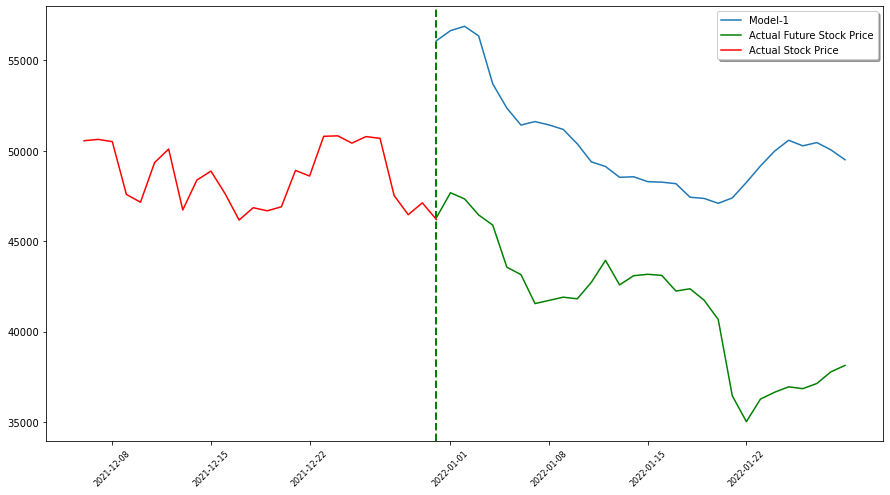

In [30]:
plot_future(df[1800:].close, [predictions_future.Prediction], predictions_future.Actual)

{'mape': '22.407%', 'mae': 9056.92819325025, 'rmse': 9508.78749651108}

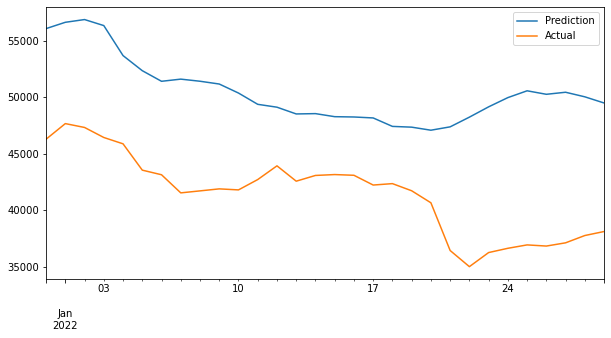

In [31]:
predictions_future.plot(figsize=(10, 5), label='Predicted Stock Price')
forecast_accuracy(predictions_future['Prediction'], predictions_future['Actual'])

In [40]:
# save model with the MAPE score
def save_model(model, model_name):
    model.save(f'./saved_models/{model_name}.h5')
    print(f'Model saved as {model_name}.h5')

In [36]:
mape = forecast_accuracy(predictions_future['Prediction'], predictions_future['Actual'])['mape'].split("%")[0]
# input("Press Enter to continue...")
save_model(model3, f'model3-{mape}')

Model saved as model3-16.054.h5


In [32]:
# make a prediction on based on the past 30 days
predictions_future4 = model4.predict(testX4[-TIMESTEPS:])
predictions_future4 = inverse_transform(predictions_future4, scaler4, len(top_predictors))
predictions_future4 = pd.DataFrame(predictions_future4, columns=['Prediction']).set_index(pd.Series(datelist_future))
predictions_future4['Actual'] = yf_df.loc[min(predictions_future4.index):max(predictions_future4.index)].Close


In [187]:
mape = forecast_accuracy(predictions_future4['Prediction'], predictions_future4['Actual'])['mape'].split("%")[0]
save_model(model4, f'model-11f-{mape}')

Model saved as model-11f-7.014.h5


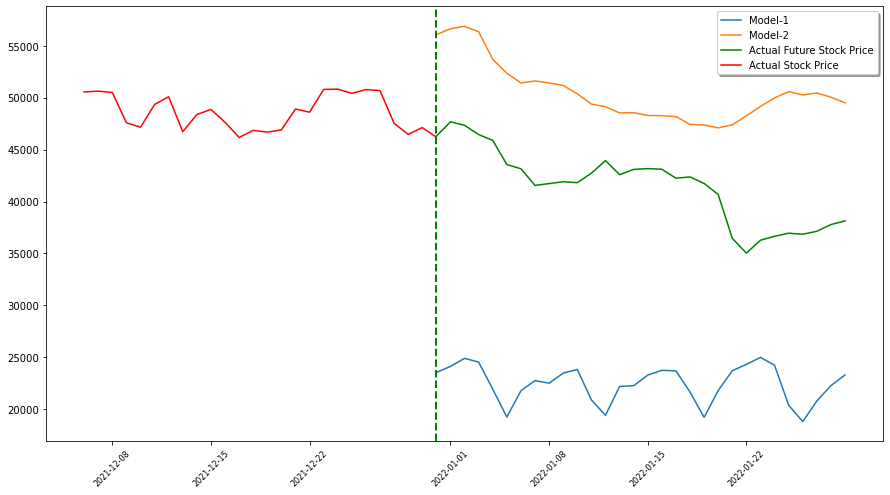

In [33]:
plot_future(df[1800:].close, [predictions_future4.Prediction,predictions_future.Prediction], predictions_future4.Actual)
# forecast_accuracy(predictions_future4['Prediction'], predictions_future4['Actual'])
